# Determining the cost of cars

The service for selling used cars is developing an application to attract new customers. Here you can quickly find out the market value of your car. Historical data is at your disposal: technical characteristics, configurations and prices of cars. You need to build a model to determine the cost.

The following are important to the customer:

- quality of prediction;
- prediction speed;
- studying time.

## Data preparation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor, cv
from lightgbm import LGBMRegressor
warnings.filterwarnings('ignore')

RANDOM_STATE=12345

In [2]:
cars=pd.read_csv('/datasets/autos.csv')

In [3]:
cars.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
120785,2016-03-29 14:51:07,3999,wagon,2008,manual,150,astra,150000,12,gasoline,opel,no,2016-03-29 00:00:00,0,88456,2016-04-06 00:44:29
340136,2016-04-04 13:39:37,2900,small,2007,manual,86,ibiza,125000,7,petrol,seat,no,2016-04-04 00:00:00,0,90425,2016-04-06 14:45:11
98671,2016-03-07 20:47:45,1000,bus,2000,manual,125,zafira,150000,12,petrol,opel,yes,2016-03-07 00:00:00,0,45527,2016-03-07 20:47:45
87131,2016-03-11 16:49:19,1100,coupe,1994,manual,116,other,150000,5,petrol,toyota,no,2016-03-11 00:00:00,0,18273,2016-03-11 16:49:19
155040,2016-03-19 20:51:00,849,small,1997,NaN,0,fiesta,150000,4,NaN,ford,NaN,2016-03-19 00:00:00,0,59457,2016-03-24 16:47:35


In [4]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
cars.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [6]:
cars=cars.drop(["DateCrawled", "DateCreated", "LastSeen", "NumberOfPictures", "PostalCode", "RegistrationMonth"], axis=1)

We remove columns that are not needed for training for models.

<AxesSubplot:xlabel='Power', ylabel='Count'>

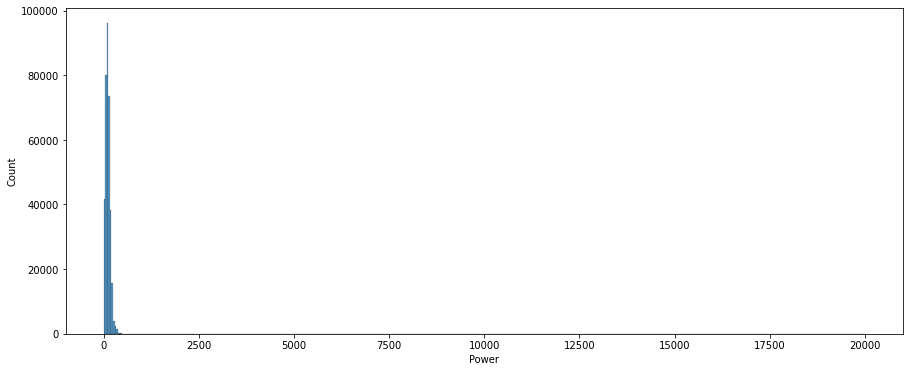

In [7]:
plt.subplots(figsize = (15, 6))
sns.histplot(cars['Power'], bins=500)

We see a wide range of power values. Let's take the range from 30 to 600 forces. Minimum - the weakest cars
(they are also called quadricycles), the maximum is exclusive sports cars.

<AxesSubplot:xlabel='Power', ylabel='Count'>

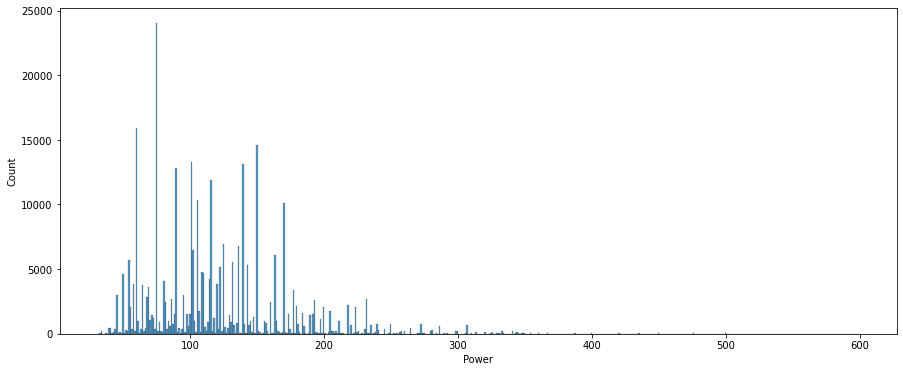

In [8]:
cars=cars[cars['Power']<600]
cars=cars[cars['Power']>30]
plt.subplots(figsize = (15, 6))
sns.histplot(cars['Power'], bins=500)

<AxesSubplot:xlabel='Kilometer', ylabel='Count'>

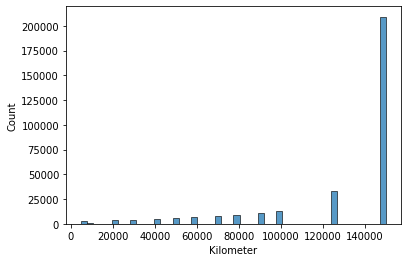

In [9]:
sns.histplot(cars['Kilometer'], bins=50)

In [10]:
cars[cars['Kilometer']>100000].describe()

,Price,RegistrationYear,Power,Kilometer
count,242620.000000,242620.000000,242620.000000,242620.000000
mean,3805.933328,2002.414912,122.723440,146566.750474
std,3888.861721,15.536459,54.206039,8604.902151
min,0.000000,1910.000000,31.000000,125000.000000
25%,1000.000000,1999.000000,80.000000,150000.000000
50%,2400.000000,2002.000000,115.000000,150000.000000
75%,5200.000000,2006.000000,150.000000,150000.000000
max,20000.000000,9000.000000,599.000000,150000.000000


There is an extremum at a mileage value of 150 thousand kilometers. This indicates an upper limit on the service website. At such long mileage, it is difficult to predict the condition of the car: a lot depends on the operating conditions and the accuracy of the drivers. Therefore, it is not so important whether the mileage is 150 or 450 thousand. We'll leave it unnamed.

<AxesSubplot:xlabel='Price', ylabel='Count'>

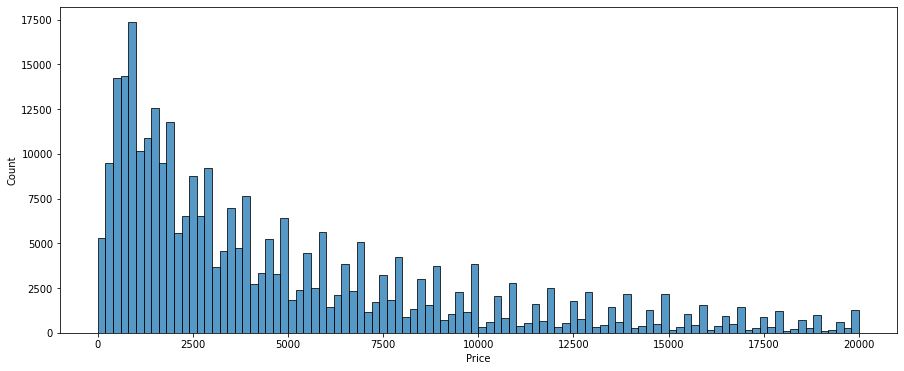

In [11]:
cars=cars[cars['Price']>0]
plt.subplots(figsize = (15, 6))
sns.histplot(cars['Price'], bins=100)

In [12]:
cars.describe()

,Price,RegistrationYear,Power,Kilometer
count,305976.000000,305976.000000,305976.000000,305976.000000
mean,4813.650061,2003.563420,120.488895,128611.394358
std,4588.526517,32.547045,53.548601,36534.048389
min,1.000000,1000.000000,31.000000,5000.000000
25%,1300.000000,1999.000000,75.000000,125000.000000
50%,3100.000000,2003.000000,110.000000,150000.000000
75%,6950.000000,2008.000000,150.000000,150000.000000
max,20000.000000,9999.000000,599.000000,150000.000000


Let's leave only those ads that have a non-zero price.
The minimum price may be indicated (1 euro) if the car is not running and is sold for spare parts.

In [13]:
cars=cars[cars['RegistrationYear']>1950]
cars=cars[cars['RegistrationYear']<2020]

<AxesSubplot:xlabel='RegistrationYear', ylabel='Count'>

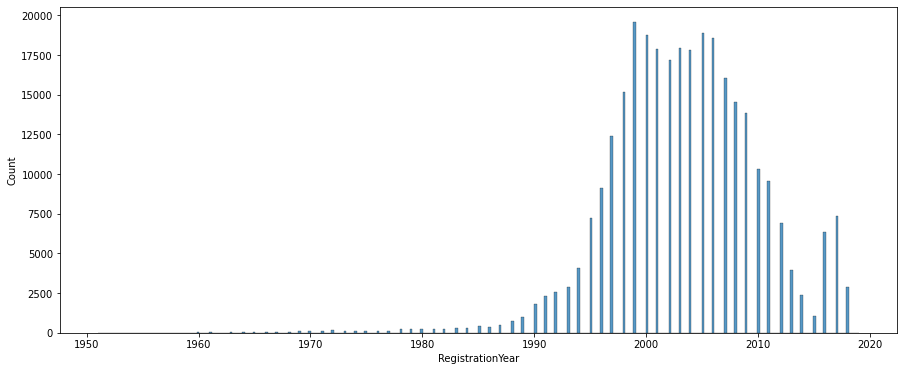

In [14]:
plt.subplots(figsize = (15, 6))
sns.histplot(cars['RegistrationYear'], bins=300)

In [15]:
cars.describe()

,Price,RegistrationYear,Power,Kilometer
count,305920.000000,305920.000000,305920.000000,305920.000000
mean,4813.098019,2003.351376,120.489968,128626.863232
std,4588.188386,6.809983,53.536033,36511.969542
min,1.000000,1951.000000,31.000000,5000.000000
25%,1300.000000,1999.000000,75.000000,125000.000000
50%,3100.000000,2003.000000,110.000000,150000.000000
75%,6950.000000,2008.000000,150.000000,150000.000000
max,20000.000000,2019.000000,599.000000,150000.000000


In [16]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305920 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             305920 non-null  int64 
 1   VehicleType       284694 non-null  object
 2   RegistrationYear  305920 non-null  int64 
 3   Gearbox           299931 non-null  object
 4   Power             305920 non-null  int64 
 5   Model             293763 non-null  object
 6   Kilometer         305920 non-null  int64 
 7   FuelType          286317 non-null  object
 8   Brand             305920 non-null  object
 9   Repaired          259123 non-null  object
dtypes: int64(4), object(6)
memory usage: 25.7+ MB


In [17]:
cars["Repaired"]=cars["Repaired"].fillna("no")
cars['Kilometer'] = cars['Kilometer'].fillna(cars['Kilometer'].mean())
cars["VehicleType"]=cars["VehicleType"].fillna("other")

In [18]:
cars['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [19]:
cars["Gearbox"]=cars["Gearbox"].fillna("other")

In [20]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305920 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             305920 non-null  int64 
 1   VehicleType       305920 non-null  object
 2   RegistrationYear  305920 non-null  int64 
 3   Gearbox           305920 non-null  object
 4   Power             305920 non-null  int64 
 5   Model             293763 non-null  object
 6   Kilometer         305920 non-null  int64 
 7   FuelType          286317 non-null  object
 8   Brand             305920 non-null  object
 9   Repaired          305920 non-null  object
dtypes: int64(4), object(6)
memory usage: 25.7+ MB


In [21]:
# КОД РЕВЬЮЕРА
263115 / 305920

0.8600777981171548

In [22]:
#Новый процент пропусков
(1-277484/305920)*100

9.295240585774057

In [23]:
cars=cars.dropna()

In [24]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277484 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             277484 non-null  int64 
 1   VehicleType       277484 non-null  object
 2   RegistrationYear  277484 non-null  int64 
 3   Gearbox           277484 non-null  object
 4   Power             277484 non-null  int64 
 5   Model             277484 non-null  object
 6   Kilometer         277484 non-null  int64 
 7   FuelType          277484 non-null  object
 8   Brand             277484 non-null  object
 9   Repaired          277484 non-null  object
dtypes: int64(4), object(6)
memory usage: 23.3+ MB


In [25]:
cars.duplicated().sum()

44674

In [26]:
cars=cars.drop_duplicates()

In [27]:
cars['IsManualGearbox'] = 0
cars.loc[cars['Gearbox'] == 'manual', 'IsManualGearbox'] = 1
display(cars['IsManualGearbox'].value_counts())
cars['Gearbox'].value_counts()

1    180665
0     52145
Name: IsManualGearbox, dtype: int64

manual    180665
auto       48274
other       3871
Name: Gearbox, dtype: int64

In [28]:
cars['IsRepaired'] = 0
cars.loc[cars['Repaired'] == 'yes', 'IsRepaired'] = 1
display(cars['IsRepaired'].value_counts())
cars['Repaired'].value_counts()

0    209043
1     23767
Name: IsRepaired, dtype: int64

no     209043
yes     23767
Name: Repaired, dtype: int64

Replaced values in the 'Repair' and 'Gearbox' columns with 0 and 1

In [29]:
cars.drop(['Repaired','Gearbox'], inplace=True, axis=1)
cars['IsRepaired'] = pd.to_numeric(cars['IsRepaired'], downcast='integer')
cars['IsManualGearbox'] = pd.to_numeric(cars['IsManualGearbox'], downcast='integer')
cars['RegistrationYear'] = pd.to_numeric(cars['RegistrationYear'], downcast='integer')
cars['Power'] = pd.to_numeric(cars['Power'], downcast='integer')
cars['Kilometer'] = pd.to_numeric(cars['Kilometer'], downcast='integer')
cars['Price'] = pd.to_numeric(cars['Price'], downcast='integer')
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232810 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             232810 non-null  int16 
 1   VehicleType       232810 non-null  object
 2   RegistrationYear  232810 non-null  int16 
 3   Power             232810 non-null  int16 
 4   Model             232810 non-null  object
 5   Kilometer         232810 non-null  int32 
 6   FuelType          232810 non-null  object
 7   Brand             232810 non-null  object
 8   IsManualGearbox   232810 non-null  int8  
 9   IsRepaired        232810 non-null  int8  
dtypes: int16(3), int32(1), int8(2), object(4)
memory usage: 11.5+ MB


Changed data types to remove extra commas and reduce memory usage.

In [30]:
cars.sample(10)

,Price,VehicleType,RegistrationYear,Power,Model,Kilometer,FuelType,Brand,IsManualGearbox,IsRepaired
124916,3950,small,2007,84,fortwo,125000,petrol,smart,0,0
82568,4300,other,2017,170,a6,150000,petrol,audi,1,0
55838,800,sedan,1990,55,golf,150000,petrol,volkswagen,1,0
53935,2000,bus,2000,116,galaxy,150000,petrol,ford,1,0
257834,8799,wagon,2010,131,insignia,150000,gasoline,opel,1,0
147480,1700,small,2008,68,c1,150000,petrol,citroen,1,1
97114,4000,sedan,2000,118,3er,150000,petrol,bmw,1,0
282555,2500,coupe,2001,218,clk,150000,lpg,mercedes_benz,0,0
321264,15550,convertible,2004,231,3er,80000,petrol,bmw,0,0
66524,4950,sedan,2009,80,golf,150000,petrol,volkswagen,1,1


### Conclusion

Unfortunately, the source data is not of very high quality. We had to do a lot of work:
1. Removed unnecessary columns.
2. Removed emissions in the “Year of Manufacture” and “Power” columns.
3. Replaced data types to improve readability and speed.
4. Removed duplicates and omissions.

## Model training

In [31]:
features = cars.drop('Price', axis=1)
target = cars['Price']

In [32]:
features_train, feat_test, target_train, tar_test = train_test_split(
    features, target, test_size=0.4, random_state=RANDOM_STATE)

features_test, features_valid, target_test, target_valid= train_test_split(
    feat_test, tar_test, test_size=0.5, random_state=RANDOM_STATE)

In [33]:
print(features_train.shape[0])
print(target_train.shape[0])
print()
print(features_test.shape[0])
print(target_test.shape[0])
print()
print(features_valid.shape[0])
print(target_valid.shape[0])
print()

139686
139686

46562
46562

46562
46562



In [34]:
scaler=StandardScaler()

In [35]:
sc_features = ['RegistrationYear', 'Power', 'Kilometer']

In [36]:
scaler.fit(features_train[sc_features])

StandardScaler()

In [37]:
features_train[sc_features] = scaler.transform(features_train[sc_features])
features_test[sc_features] = scaler.transform(features_test[sc_features])
features_valid[sc_features] = scaler.transform(features_valid[sc_features])

In [38]:
ordinal_features = features_train.select_dtypes(include='object').columns.to_list()
ordinal_features

['VehicleType', 'Model', 'FuelType', 'Brand']

In [39]:
encoder_ordinal = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [40]:
encoder_ordinal.fit(features_train[ordinal_features])

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [41]:
features_train_ordinal = features_train.copy()
features_test_ordinal = features_test.copy()
features_valid_ordinal = features_valid.copy()

In [42]:
features_train_ordinal[ordinal_features] = encoder_ordinal.transform(features_train_ordinal[ordinal_features])
features_test_ordinal[ordinal_features] = encoder_ordinal.transform(features_test_ordinal[ordinal_features])
features_valid_ordinal[ordinal_features] = encoder_ordinal.transform(features_valid_ordinal[ordinal_features])

### DecisionTreeRegressor

In [43]:
%%time

regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 31)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[RANDOM_STATE]}]

clf_dt = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf_dt.fit(features_train_ordinal, target_train)
print("Best parameters:", clf_dt.best_params_)
best= clf_dt.cv_results_['mean_test_score']
mean=clf_dt.cv_results_['mean_test_score'].mean()
print("Best RMSE:", (max(best)*-1) ** 0.5)
print("Mean RMSE:", (mean*-1) ** 0.5)

Best parameters: {'criterion': 'mse', 'max_depth': 13, 'random_state': 12345}
Best RMSE: 1988.6642237827937
Mean RMSE: 2222.547355640356
CPU times: user 35.3 s, sys: 50.9 ms, total: 35.3 s
Wall time: 35.9 s


### CatboostRegressor

In [44]:
%%time

regressor = CatBoostRegressor() 
hyperparams = [{'learning_rate':[0.1, 0.5, 0.8],
                'random_state':[RANDOM_STATE],
                'verbose':[False]}]

clf_cb = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf_cb.fit(features_train_ordinal, target_train)
print("Best parameters:", clf_dt.best_params_)
best= clf_cb.cv_results_['mean_test_score']
mean=clf_cb.cv_results_['mean_test_score'].mean()
print("Best RMSE:", (max(best)*-1) ** 0.5)
print("Mean RMSE:", (mean*-1) ** 0.5)

Best parameters: {'criterion': 'mse', 'max_depth': 13, 'random_state': 12345}
Best RMSE: 1645.4298410266933
Mean RMSE: 1659.6763023382143
CPU times: user 3min 25s, sys: 1.74 s, total: 3min 27s
Wall time: 3min 42s


### LGBMRegressor

In [45]:
%%time

regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[100, 200], 
                'learning_rate':[0.1, 0.3, 0.5],
                'random_state':[RANDOM_STATE]}]

clf_lgb = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf_lgb.fit(features_train_ordinal, target_train)
print("Best parameters:", clf_lgb.best_params_)
best= clf_lgb.cv_results_['mean_test_score']
mean=clf_lgb.cv_results_['mean_test_score'].mean()
print("Best RMSE:", (max(best)*-1) ** 0.5)
print("Mean RMSE:", (mean*-1) ** 0.5)

Best parameters: {'learning_rate': 0.1, 'num_leaves': 200, 'random_state': 12345}
Best RMSE: 1630.873157485926
Mean RMSE: 1654.6788992220452
CPU times: user 6min 17s, sys: 2.37 s, total: 6min 19s
Wall time: 6min 24s


### Conclusion

We selected hyperparameters for 3 models: DecisionTree, CatBoost and LightGBM

## Model analysis

### DecisionTreeRegressor

In [46]:
%%time
start=time.time()
model = DecisionTreeRegressor(**clf_dt.best_params_) 
model.fit(features_train_ordinal, target_train)
end=time.time()
DT_fit_time=end-start
DT_fit_time

CPU times: user 279 ms, sys: 143 µs, total: 279 ms
Wall time: 308 ms


0.3083832263946533

In [47]:
%%time
start=time.time()
target_predict = model.predict(features_test_ordinal)
end=time.time()
DT_predict_time=end-start
DT_predict_time

CPU times: user 11 ms, sys: 0 ns, total: 11 ms
Wall time: 9.67 ms


0.009606122970581055

In [48]:
DT_rmse = mean_squared_error(target_test, target_predict) ** 0.5
DT_rmse

1965.5797663573135

### CatBoostRegressor

In [49]:
%%time
start=time.time()
model = CatBoostRegressor(**clf_cb.best_params_) 
model.fit(features_train_ordinal, target_train)
end=time.time()
CBR_fit_time=end-start
CBR_fit_time

CPU times: user 15.5 s, sys: 98.6 ms, total: 15.6 s
Wall time: 16.7 s


16.655490398406982

In [50]:
%%time
start=time.time()
target_predict = model.predict(features_test_ordinal)
end=time.time()
CBR_predict_time=end-start
CBR_predict_time

CPU times: user 43.4 ms, sys: 0 ns, total: 43.4 ms
Wall time: 42.2 ms


0.042122840881347656

In [51]:
CBR_rmse = mean_squared_error(target_test, target_predict) ** 0.5
CBR_rmse

1615.838484473922

### LGBMRegressor

In [52]:
%%time
start=time.time()
model = LGBMRegressor(**clf_lgb.best_params_)
model.fit(features_train_ordinal, target_train)
end=time.time()
LGBM_fit_time=end-start
LGBM_fit_time

CPU times: user 10.7 s, sys: 78.1 ms, total: 10.8 s
Wall time: 10.8 s


10.842126369476318

In [53]:
%%time
start=time.time()
target_predict = model.predict(features_test_ordinal)
end=time.time()
LGBM_predict_time=end-start
LGBM_predict_time

CPU times: user 524 ms, sys: 0 ns, total: 524 ms
Wall time: 511 ms


0.510408878326416

In [54]:
LGBM_rmse= mean_squared_error(target_test, target_predict) ** 0.5
LGBM_rmse

1607.978352338832

### Comparison of models

In [55]:
columns=['DecisionTreeRegressor', 'CatBoostRegressor', 'LGBMRegressor']
info={'Bремя обучения модели, мс':[DT_fit_time, CBR_fit_time, LGBM_fit_time],
     'Время предсказания, мс':[DT_predict_time, CBR_predict_time, LGBM_predict_time],
     'RMSE':[DT_rmse, CBR_rmse, LGBM_rmse]}
final_result=pd.DataFrame(data=info, index=columns)
final_result['Bремя обучения модели, мс']=final_result['Bремя обучения модели, мс']*1000
final_result['Bремя обучения модели, мс']=final_result['Bремя обучения модели, мс'].astype('int')
final_result['Время предсказания, мс']=final_result['Время предсказания, мс']*1000
final_result['Время предсказания, мс']=final_result['Время предсказания, мс'].astype('int')
final_result['RMSE']=final_result['RMSE'].astype('int')
final_result

,"Bремя обучения модели, мс","Время предсказания, мс",RMSE
DecisionTreeRegressor,308,9,1965
CatBoostRegressor,16655,42,1615
LGBMRegressor,10842,510,1607


### Валидация CatBoost

In [56]:
%%time
model = CatBoostRegressor(**clf_cb.best_params_) 
model.fit(features_train_ordinal, target_train)

CPU times: user 15.6 s, sys: 83.3 ms, total: 15.7 s
Wall time: 16.7 s


In [57]:
%%time
target_predict = model.predict(features_valid_ordinal)

CPU times: user 43.1 ms, sys: 40 µs, total: 43.1 ms
Wall time: 41.6 ms


In [58]:
CBR_rmse_valid = mean_squared_error(target_valid, target_predict) ** 0.5
CBR_rmse_valid

1632.3204792087918

### Conclusion

After comparing the 3 models, we can draw the following conclusions:
1. Decision Tree learns the fastest, 25 and 62 times, respectively.
2. In terms of prediction time, the Solution Tree is also in the lead, but the superiority is not so significant: 4 and 50 times.
3. But with the RMSE metric the situation is the opposite: the LightGBM model itself is the most accurate, CatBoost has almost the same accuracy, and Decision Tree is 19% worse.

## Conclusion

1. Completed data preparation. Unfortunately, there are too many omissions, outliers and inaccuracies.
2. We made a selection of hyperparameters for 3 models.
3. Analyzed the performance of the resulting models.

All models confidently exceeded the RMSE requirement:

Decision Tree: 1965

CatBoost: 1615

LightGBM: 1607

Each model can be used for different tasks:

a) DecisionTree is the fastest and can be used to roughly estimate a car.

b) LightGBM predicts the cost most accurately, but also takes a long time to work. Suitable for evaluating the most expensive and rare cars, where accuracy is especially important.

c) The optimal solution is CatBoost. It takes a long time to train, but the prediction time is an order of magnitude lower than that of LightGBM, and the difference in accuracy is less than 0.5%